# 01 - Uploading, Reading, & Preprocessing Image Data

### 1. Imports

In [2]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# os & image imports
import os
from PIL import Image

# tensorflow
import tensorflow as tf

# keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall, SpecificityAtSensitivity, SensitivityAtSpecificity

# sklearn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split # need this to split the train set into train/test for model training

To read the data in and also store the labels, I am going to make a dataframe by iterating through the contents of the `archive` folder under the `data` directory. Each images are further split into `Testing` and `Training` folders, each with separate directories for images corresponding to the type of tumor: Glioma, Meningioma, Pituitary, No Tumor.

In [3]:
# define paths to test & train directories
test_directory = '/content/drive/MyDrive/data/archive/Testing'
train_directory = '/content/drive/MyDrive/data/archive/Training'

---
### 2. Manual Preprocessing

In [4]:
def image_to_df(filepath):

    base = os.listdir(filepath)
    base.remove('.DS_Store') # removes this element from the list, remaining should be the actual folders

    label = []
    img_path = []
    folder_path = []

    for folder_name in base:
        images = os.listdir(filepath + f'/{folder_name}')
        for i in images:
            if i.endswith(".jpg"):
                label.append(folder_name)
                img_path.append(f'{filepath}/{folder_name}/{i}')
                folder_path.append(f'{filepath}/{folder_name}')

    return pd.DataFrame(data={'folder_path': folder_path,'img_path': img_path, 'label': label})

In [5]:
# storing the output of the function for test data
test_df = image_to_df(test_directory)

In [6]:
# storing the output of the function for train data
train_df = image_to_df(train_directory)

In [7]:
test_df.head()

,folder_path,img_path,label
0,/content/drive/MyDrive/data/archive/Testing/no...,/content/drive/MyDrive/data/archive/Testing/no...,notumor
1,/content/drive/MyDrive/data/archive/Testing/no...,/content/drive/MyDrive/data/archive/Testing/no...,notumor
2,/content/drive/MyDrive/data/archive/Testing/no...,/content/drive/MyDrive/data/archive/Testing/no...,notumor
3,/content/drive/MyDrive/data/archive/Testing/no...,/content/drive/MyDrive/data/archive/Testing/no...,notumor
4,/content/drive/MyDrive/data/archive/Testing/no...,/content/drive/MyDrive/data/archive/Testing/no...,notumor


In [8]:
train_df.head()

,folder_path,img_path,label
0,/content/drive/MyDrive/data/archive/Training/m...,/content/drive/MyDrive/data/archive/Training/m...,meningioma
1,/content/drive/MyDrive/data/archive/Training/m...,/content/drive/MyDrive/data/archive/Training/m...,meningioma
2,/content/drive/MyDrive/data/archive/Training/m...,/content/drive/MyDrive/data/archive/Training/m...,meningioma
3,/content/drive/MyDrive/data/archive/Training/m...,/content/drive/MyDrive/data/archive/Training/m...,meningioma
4,/content/drive/MyDrive/data/archive/Training/m...,/content/drive/MyDrive/data/archive/Training/m...,meningioma


**NOTE:** I went back after the fact to add this. I did not have a separate validation dataset before. I will use train/test/split from sklearn to split my `train_df` further into train/validation set, so that when I train my CNN model, it will not see the testing data. <br>

I will have 30% of the train data for validation purposes, and the remaining for training the CNN. There are 5712 images total in the train set, so this should be enough for the model to learn.

In [9]:
train_df, val_df = train_test_split(train_df, test_size = 0.30, train_size = 0.70, stratify = train_df['label'])

Let's quickly look to see class proportions in the dataset.

In [10]:
round(train_df['label'].value_counts(normalize = True), 2)

notumor       0.28
pituitary     0.26
meningioma    0.23
glioma        0.23
Name: label, dtype: float64

In [11]:
print('This should be very roughly the same as the train_df')
round(val_df['label'].value_counts(normalize = True), 2)

This should be very roughly the same as the train_df


notumor       0.28
pituitary     0.26
meningioma    0.23
glioma        0.23
Name: label, dtype: float64

In [12]:
round(test_df['label'].value_counts(normalize = True), 2)

notumor       0.31
meningioma    0.23
pituitary     0.23
glioma        0.23
Name: label, dtype: float64

In [79]:
print(f'Images in Training across all 4 classes: {len(train_df)}')
print("===============================================")
print(f'Images in Validation across all 4 classes: {len(val_df)}')
print("===============================================")
print(f'Images in Testing across all 4 classes: {len(test_df)}')

Images in Training across all 4 classes: 4005
Images in Validation across all 4 classes: 1717
Images in Testing across all 4 classes: 1311


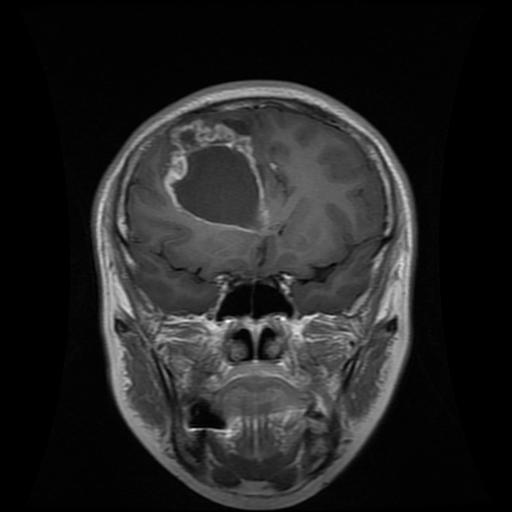

In [14]:
# let's take a look at some image samples
Image.open(train_df.iloc[0,1])

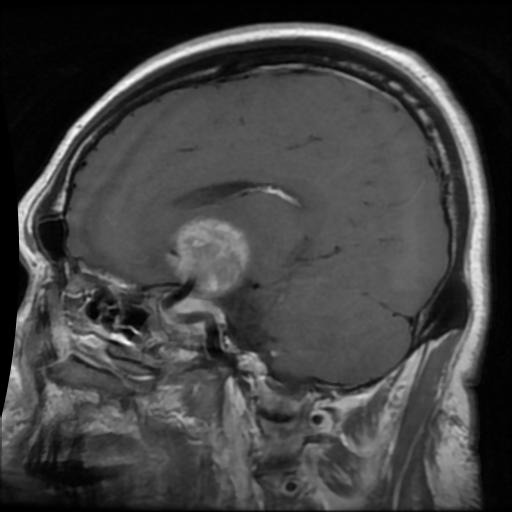

In [15]:
Image.open(train_df.iloc[45,1])

In [16]:
#### EDA CAN BE PERFORMED HERE ON THE CLASS LABELS AND PORTION OF EACH CLASS (or in a separate jpynb)

---
### 3. Preprocessing with `ImageDataGenerator()`

In [90]:
# instantiate ImageDataGenerator Class (called 'idg') for train and val
idg_train = ImageDataGenerator(rescale = 1./255,
                               brightness_range=(0.6, 1.4),)

idg_val = ImageDataGenerator(rescale = 1./255,
                             brightness_range=(0.6, 1.4),)


# keep testing separate
idg_test = ImageDataGenerator(rescale = 1./255,)

#### **1. Training Data Generator**

In [91]:
train_data_gen = idg_train.flow_from_dataframe(train_df,
                             x_col = 'img_path',
                             y_col = 'label',
                             class_mode = 'categorical',
                             target_size = (256,256),
                             batch_size = 32,
                             color_mode = 'rgb',
                             classes = {'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}) # setting the default class indices

Found 4005 validated image filenames belonging to 4 classes.


In [92]:
# dictionary - numerical representations for each categorical var
train_data_gen.class_indices

{'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}

#### **2. Validation Data Generator**

In [93]:
# the set up here should be the same as 'train_data_gen'
val_data_gen = idg_val.flow_from_dataframe(val_df,
                             x_col = 'img_path',
                             y_col = 'label',
                             class_mode = 'categorical',
                             target_size = (256,256),
                             batch_size = 32,
                             color_mode = 'rgb',
                             shuffle = False,
                             classes = {'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}) # setting the default class indices

Found 1717 validated image filenames belonging to 4 classes.


In [94]:
# dictionary - numerical representations for each categorical var
val_data_gen.class_indices

{'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}

#### **3. Testing Data Generator**

In [95]:
test_data_gen = idg_test.flow_from_dataframe(test_df,
                             x_col = 'img_path',
                             y_col = 'label',
                             class_mode = 'categorical',
                             target_size = (256,256),
                             batch_size = 32,
                             color_mode = 'rgb',
                             shuffle = False,
                             classes = {'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}) # setting the default class indices

Found 1311 validated image filenames belonging to 4 classes.


In [96]:
# ensure labels are presented the same as train
test_data_gen.class_indices

{'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}

In [97]:
print(train_data_gen.image_shape)
print(val_data_gen.image_shape)
print(test_data_gen.image_shape)

# this is accurate (256x256 size) and 1 for the channel (black/white)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


---
### 4. Building the First Model

In [98]:
# instantiating Sequential model, 'model_1'
model_1 = Sequential()

# layer 1
model_1.add(Conv2D(32, 3, activation = "relu", input_shape = (256, 256, 3))) # input shape is 256 x 256, 1 channel
model_1.add(MaxPooling2D(pool_size = 2))

# layer 2
model_1.add(Conv2D(64, 3, activation = "relu",)) # NOTE: no need for an additional input shape here, only needed for the first blocj
model_1.add(MaxPooling2D(pool_size = 2))

# flatten
model_1.add(Flatten())

# output layer
model_1.add(Dense(4, activation = 'softmax')) # we want 4 outputs (4 classes) and 'softmax' activation to give us the probability

# let's view a summary of model_1
print(f"Model Summary:")
print("="*20)
print(model_1.summary())

# compiling the model
model_1.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy', # need categorical_crossentropy since multiclass classification
               metrics = ['accuracy', Precision(), Recall()])

Model Summary:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 246016)            0         
                                                                 
 dense_6 (Dense)             (None, 4) 

In [99]:
# fitting the model to training data
history_1 = model_1.fit(train_data_gen, epochs = 10, validation_data = val_data_gen, shuffle = False)

Epoch 1/10
126/126 [==============================] - 29s 222ms/step - loss: 0.8679 - accuracy: 0.7061 - precision_4: 0.7719 - recall_4: 0.6075 - val_loss: 0.4956 - val_accuracy: 0.8136 - val_precision_4: 0.8354 - val_recall_4: 0.7921
Epoch 2/10
126/126 [==============================] - 28s 223ms/step - loss: 0.3219 - accuracy: 0.8866 - precision_4: 0.9010 - recall_4: 0.8749 - val_loss: 0.7166 - val_accuracy: 0.7373 - val_precision_4: 0.7430 - val_recall_4: 0.7309
Epoch 3/10
126/126 [==============================] - 29s 227ms/step - loss: 0.1651 - accuracy: 0.9423 - precision_4: 0.9469 - recall_4: 0.9388 - val_loss: 0.4020 - val_accuracy: 0.8882 - val_precision_4: 0.8935 - val_recall_4: 0.8847
Epoch 4/10
126/126 [==============================] - 29s 230ms/step - loss: 0.0765 - accuracy: 0.9743 - precision_4: 0.9764 - recall_4: 0.9725 - val_loss: 0.3914 - val_accuracy: 0.8923 - val_precision_4: 0.8944 - val_recall_4: 0.8882
Epoch 5/10
126/126 [==============================] - 28s 22

---

### 5. Evaluating the Model

In [100]:
# the .history attribute outputs a dictionary of the metrics over each epoch the model ran for both training and validation sets
history_1.history

{'loss': [0.8678580522537231,
  0.32191193103790283,
  0.16514720022678375,
  0.0765305906534195,
  0.03703060373663902,
  0.04187095910310745,
  0.018943021073937416,
  0.015179683454334736,
  0.011409950442612171,
  0.010698865167796612],
 'accuracy': [0.7061173319816589,
  0.8866416811943054,
  0.9423220753669739,
  0.9742821455001831,
  0.9887640476226807,
  0.9902621507644653,
  0.9945068955421448,
  0.9960049986839294,
  0.9970037341117859,
  0.9967540502548218],
 'precision_4': [0.7718908786773682,
  0.901002824306488,
  0.9468647837638855,
  0.9764351844787598,
  0.9892473220825195,
  0.9905071258544922,
  0.9945068955421448,
  0.9960049986839294,
  0.9970037341117859,
  0.9967540502548218],
 'recall_4': [0.6074906587600708,
  0.8749063611030579,
  0.9388264417648315,
  0.9725343585014343,
  0.9877653121948242,
  0.9900124669075012,
  0.9945068955421448,
  0.9960049986839294,
  0.9970037341117859,
  0.9967540502548218],
 'val_loss': [0.4955854117870331,
  0.7166063189506531,
  

#### 1. **Graphing Training vs. Validation Loss, Accuracy, Precision, & Recall**

In [101]:
history_1.history.keys()

dict_keys(['loss', 'accuracy', 'precision_4', 'recall_4', 'val_loss', 'val_accuracy', 'val_precision_4', 'val_recall_4'])

In [103]:
# let's save the history output in separate lists
train_loss = history_1.history['loss']
train_acc = history_1.history['accuracy']
train_precision = history_1.history['precision_4']
train_recall = history_1.history['recall_4']

val_loss = history_1.history['val_loss']
val_acc = history_1.history['val_accuracy']
val_precision = history_1.history['val_precision_4']
val_recall = history_1.history['val_recall_4']

epochs = [i+1 for i in history_1.epoch] # quick list comprehension since the original epochs list is from 0 - 9

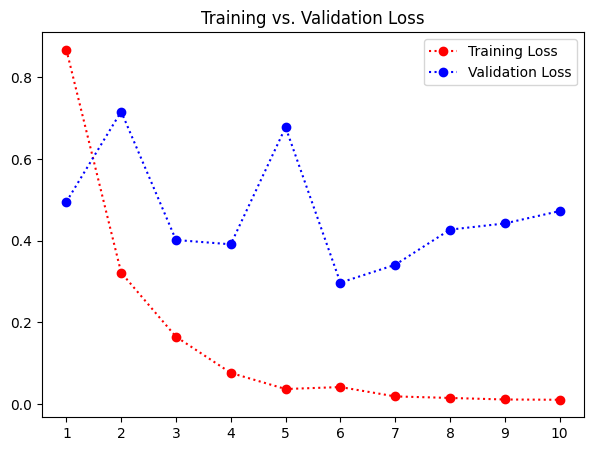

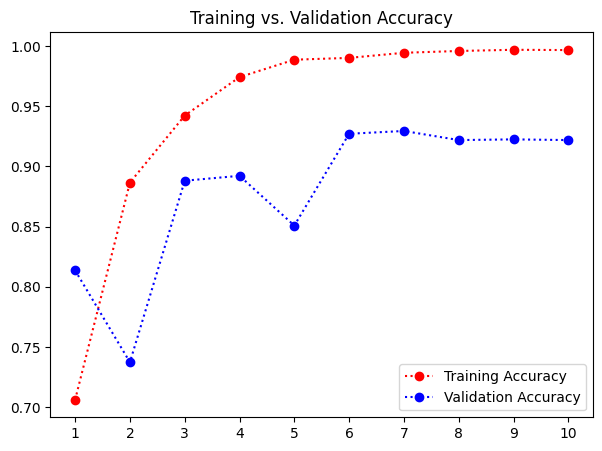

In [104]:
# plotting
plt.figure(figsize = (7,5))
plt.plot(epochs, train_loss, 'o:r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'o:b', label = 'Validation Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.xticks(epochs)
plt.savefig('/content/drive/MyDrive/graphs/train_val_loss.jpeg', dpi = 1080);

# some overfitting, but not extremely overfit
# validation loss ceases to improve after 7th epoch

plt.figure(figsize = (7,5))
plt.plot(epochs, train_acc, 'o:r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'o:b', label = 'Validation Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.xticks(epochs)
plt.savefig('/content/drive/MyDrive/graphs/train_val_accuracy.jpeg', dpi = 1080);

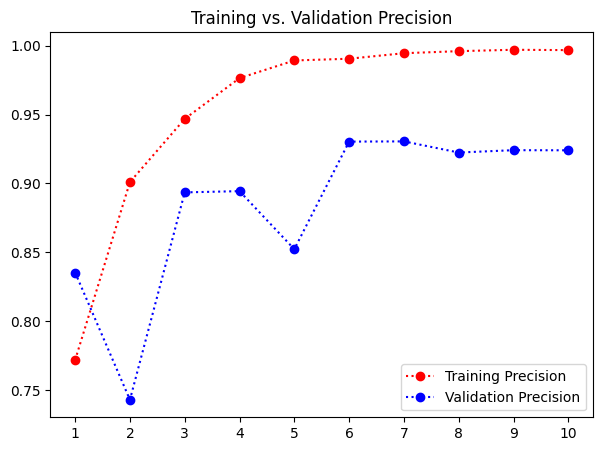

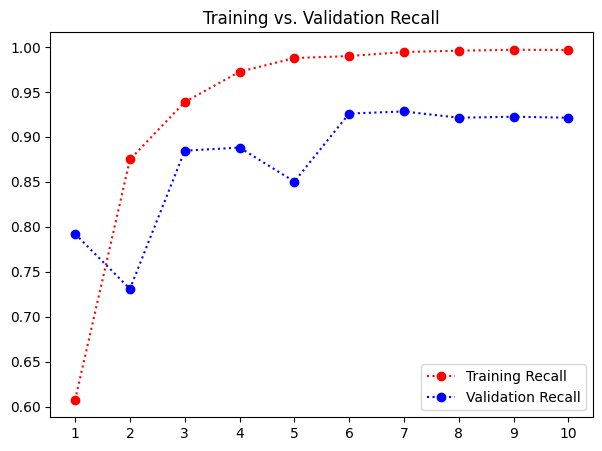

In [105]:
# plotting
plt.figure(figsize = (7,5))
plt.plot(epochs, train_precision, 'o:r', label = 'Training Precision')
plt.plot(epochs, val_precision, 'o:b', label = 'Validation Precision')
plt.legend()
plt.title('Training vs. Validation Precision')
plt.xticks(epochs)
plt.savefig('/content/drive/MyDrive/graphs/train_val_precision.jpeg', dpi = 1080);

# some overfitting, but not extremely overfit
# validation loss ceases to improve after 7th epoch

plt.figure(figsize = (7,5))
plt.plot(epochs, train_recall, 'o:r', label = 'Training Recall')
plt.plot(epochs, val_recall, 'o:b', label = 'Validation Recall')
plt.legend()
plt.title('Training vs. Validation Recall')
plt.xticks(epochs)
plt.savefig('/content/drive/MyDrive/graphs/train_val_recall.jpeg', dpi = 1080);

[EXPLANATION HERE]

In [106]:
# let's evaluate the model on the testing dataset now
model_1.evaluate(test_data_gen)

41/41 [==============================] - 5s 117ms/step - loss: 0.4959 - accuracy: 0.9230 - precision_4: 0.9258 - recall_4: 0.9230


[0.49590909481048584, 0.922959566116333, 0.9257842302322388, 0.922959566116333]

#### 2. Generating Predictions & Confusion Matrix

In [109]:
preds_1_probs = model_1.predict(test_data_gen)

41/41 [==============================] - 5s 118ms/step


In [110]:
preds_1_probs

array([[9.79148924e-01, 2.35918735e-04, 2.06080917e-02, 7.04014246e-06],
       [9.99998689e-01, 6.89646651e-09, 3.32900953e-07, 9.40275640e-07],
       [9.99999762e-01, 2.96603758e-07, 5.49146178e-13, 1.30564270e-25],
       ...,
       [1.31344223e-06, 1.25744432e-01, 8.58982921e-01, 1.52713591e-02],
       [1.87812184e-08, 5.14858039e-06, 9.99994874e-01, 1.74284835e-13],
       [1.15679946e-07, 7.03870819e-06, 9.92808819e-01, 7.18405796e-03]],
      dtype=float32)

In [111]:
preds_1 = np.argmax(preds_1_probs, axis = 1)
preds_1

array([0, 0, 0, ..., 2, 2, 2])

In [112]:
# creating a confusion matrix
conf_matrix = confusion_matrix(test_data_gen.classes, preds_1)

conf_matrix = ConfusionMatrixDisplay(conf_matrix, display_labels = test_data_gen.class_indices)

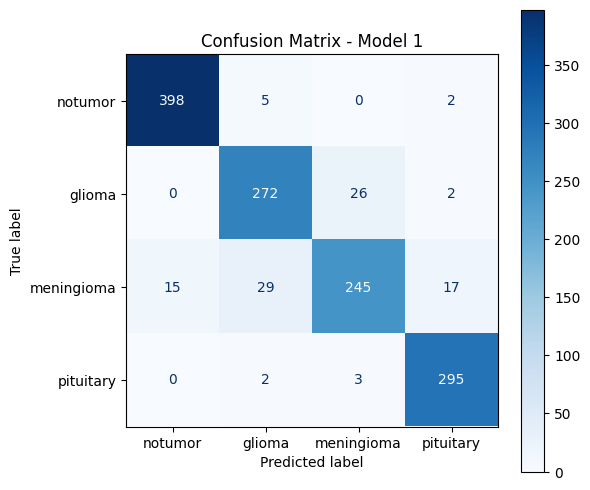

In [113]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
conf_matrix.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix - Model 1')
plt.savefig('/content/drive/MyDrive/graphs/cm_model1.jpeg', dpi = 1080)
plt.show()

In [114]:
(preds_1 == test_data_gen.classes).mean()

0.9229595728451564

In [117]:
# saving model 1 (in both formats just in case)
model_1.save('/content/drive/MyDrive/cnn_models/model1.h5')
model_1.save('/content/drive/MyDrive/cnn_models/model1.keras')

[EXPLANATION HERE]

### Xception Model

In [119]:
# instantiate Xception class
pretrained_base = tf.keras.applications.Xception(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3), pooling = 'max')

# instantiating Sequential model, 'model_1'
model_2 = Sequential(pretrained_base)

# flatten
model_2.add(Flatten())
model_2.add(Dropout(0.20))

# adding dense layers
model_2.add(Dense(64, activation = "relu"))
model_2.add(Dropout(0.20))

# output layer
model_2.add(Dense(4, activation = 'softmax')) # we want 4 outputs (4 classes) and 'softmax' activation to give us the probability


# let's view a summary of model_1
print(f"Model Summary:")
print("="*20)
print(model_2.summary())

# compiling the model
model_2.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy', # need categorical_crossentropy since multiclass classification
               metrics = ['accuracy', Precision(), Recall()])

Model Summary:
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 64)                131136    
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 4)                 260       
                                                                 
Total params: 20992876 (80.08 MB)
Train

In [120]:
history_2 = model_2.fit(train_data_gen, epochs = 10, validation_data = val_data_gen, shuffle = True)

Epoch 1/10
126/126 [==============================] - 45s 245ms/step - loss: 0.9901 - accuracy: 0.5658 - precision_6: 0.8627 - recall_6: 0.3576 - val_loss: 2.7229 - val_accuracy: 0.5405 - val_precision_6: 0.5412 - val_recall_6: 0.5277
Epoch 2/10
126/126 [==============================] - 29s 233ms/step - loss: 0.2672 - accuracy: 0.9106 - precision_6: 0.9332 - recall_6: 0.8896 - val_loss: 0.9676 - val_accuracy: 0.7886 - val_precision_6: 0.7967 - val_recall_6: 0.7851
Epoch 3/10
126/126 [==============================] - 29s 230ms/step - loss: 0.1799 - accuracy: 0.9491 - precision_6: 0.9599 - recall_6: 0.9391 - val_loss: 2.3980 - val_accuracy: 0.7595 - val_precision_6: 0.7632 - val_recall_6: 0.7566
Epoch 4/10
126/126 [==============================] - 29s 231ms/step - loss: 0.1063 - accuracy: 0.9673 - precision_6: 0.9742 - recall_6: 0.9608 - val_loss: 1.0461 - val_accuracy: 0.8725 - val_precision_6: 0.8745 - val_recall_6: 0.8725
Epoch 5/10
126/126 [==============================] - 29s 22

In [121]:
history_2.history

{'loss': [0.990114688873291,
  0.26724761724472046,
  0.17994564771652222,
  0.10631521046161652,
  0.097648486495018,
  0.10586709529161453,
  0.05108984187245369,
  0.06107957288622856,
  0.050600722432136536,
  0.028767365962266922],
 'accuracy': [0.5657927393913269,
  0.9106117486953735,
  0.9490636587142944,
  0.9672908782958984,
  0.9735330939292908,
  0.974032461643219,
  0.9852684140205383,
  0.9847690463066101,
  0.987265944480896,
  0.9932584166526794],
 'precision_6': [0.8626505732536316,
  0.933211088180542,
  0.9599285125732422,
  0.9741772413253784,
  0.9800000190734863,
  0.9803377985954285,
  0.9869674444198608,
  0.9864423871040344,
  0.9882293939590454,
  0.9939939975738525],
 'recall_6': [0.35755306482315063,
  0.8896379470825195,
  0.9390761256217957,
  0.960798978805542,
  0.9665418267250061,
  0.9710361957550049,
  0.9832708835601807,
  0.9810237288475037,
  0.9852684140205383,
  0.9917603135108948],
 'val_loss': [2.7228927612304688,
  0.9676375985145569,
  2.3979

In [125]:
preds_2_probs = model_2.predict(test_data_gen)

41/41 [==============================] - 5s 126ms/step


In [126]:
preds_2_probs

array([[3.3025246e-02, 2.6659679e-03, 9.6172845e-01, 2.5803798e-03],
       [1.0000000e+00, 3.1575805e-13, 2.9170577e-08, 1.3707164e-09],
       [9.9992311e-01, 9.9848152e-10, 7.6860466e-05, 1.1636492e-08],
       ...,
       [1.0859522e-10, 1.3564924e-09, 1.0000000e+00, 3.7908534e-09],
       [6.1193731e-13, 5.1104093e-14, 1.0000000e+00, 5.6357485e-11],
       [7.4129822e-03, 7.8911401e-02, 8.6961824e-01, 4.4057343e-02]],
      dtype=float32)

In [127]:
preds_2 = np.argmax(preds_2_probs, axis = 1)

In [128]:
# creating a confusion matrix
conf_matrix_2 = confusion_matrix(test_data_gen.classes, preds_2)

conf_matrix_2 = ConfusionMatrixDisplay(conf_matrix_2, display_labels = test_data_gen.class_indices)

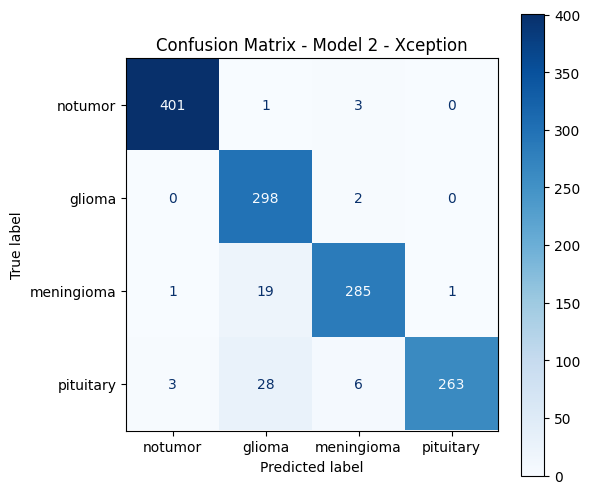

In [129]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
conf_matrix_2.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix - Model 2 - Xception')
plt.savefig('/content/drive/MyDrive/graphs/cm_model2.jpeg', dpi = 1080)
plt.show()

In [130]:
(preds_2 == test_data_gen.classes).mean()

0.9511823035850496

In [131]:
# saving Xception
model_2.save('/content/drive/MyDrive/cnn_models/model2.h5')
model_2.save('/content/drive/MyDrive/cnn_models/model2.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### VGG16 Model

In [132]:
# instantiate VGG16 class
pretrained_base = tf.keras.applications.VGG16(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3), pooling = 'max')

# instantiating Sequential model, 'model_1'
model_3 = Sequential(pretrained_base)

# flatten
model_3.add(Flatten())
model_3.add(Dropout(0.20))

# adding dense layers
model_3.add(Dense(64, activation = "relu"))
model_3.add(Dropout(0.20))

# output layer
model_3.add(Dense(4, activation = 'softmax')) # we want 4 outputs (4 classes) and 'softmax' activation to give us the probability


# let's view a summary of model_1
print(f"Model Summary:")
print("="*20)
print(model_3.summary())

# compiling the model
model_3.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy', # need categorical_crossentropy since multiclass classification
               metrics = ['accuracy', Precision(), Recall()])

58889256/58889256 [==============================] - 0s 0us/step
Model Summary:
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_7 (Flatten)         (None, 512)               0         
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                32832     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 4)                 260       
                                        

In [133]:
history_3 = model_3.fit(train_data_gen, epochs = 10, validation_data = val_data_gen, shuffle = True)

Epoch 1/10
126/126 [==============================] - 40s 245ms/step - loss: 343.5314 - accuracy: 0.2752 - precision_7: 0.3038 - recall_7: 0.0257 - val_loss: 1.2959 - val_accuracy: 0.4613 - val_precision_7: 1.0000 - val_recall_7: 0.0099
Epoch 2/10
126/126 [==============================] - 30s 240ms/step - loss: 1.4829 - accuracy: 0.2839 - precision_7: 0.3492 - recall_7: 0.0257 - val_loss: 1.4138 - val_accuracy: 0.2790 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 3/10
126/126 [==============================] - 30s 237ms/step - loss: 1.3886 - accuracy: 0.2754 - precision_7: 0.5000 - recall_7: 0.0037 - val_loss: 1.3838 - val_accuracy: 0.2790 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 4/10
126/126 [==============================] - 29s 228ms/step - loss: 1.3903 - accuracy: 0.2754 - precision_7: 0.4146 - recall_7: 0.0042 - val_loss: 1.3578 - val_accuracy: 0.2790 - val_precision_7: 1.0000 - val_recall_7: 0.0012
Epoch 5/10
126/126 [======================

In [134]:
history_3.history

{'loss': [343.5314025878906,
  1.4829306602478027,
  1.38856041431427,
  1.3902605772018433,
  1.2774021625518799,
  1.055414080619812,
  0.9518365263938904,
  0.8728720545768738,
  0.8096310496330261,
  0.7099512815475464],
 'accuracy': [0.27515605092048645,
  0.2838951349258423,
  0.27540573477745056,
  0.27540573477745056,
  0.38926342129707336,
  0.5318351984024048,
  0.5825218558311462,
  0.6289637684822083,
  0.6549313068389893,
  0.7038701772689819],
 'precision_7': [0.30383479595184326,
  0.349152535200119,
  0.5,
  0.4146341383457184,
  0.6949428915977478,
  0.6527554988861084,
  0.6674689054489136,
  0.6958654522895813,
  0.7265780568122864,
  0.7577844262123108],
 'recall_7': [0.025717852637171745,
  0.025717852637171745,
  0.00374531839042902,
  0.004244694020599127,
  0.10636704415082932,
  0.3046192228794098,
  0.4154806435108185,
  0.4958801567554474,
  0.5460674166679382,
  0.6319600343704224],
 'val_loss': [1.2959388494491577,
  1.4138391017913818,
  1.3838475942611694

In [135]:
preds_3_probs = model_3.predict(test_data_gen)

41/41 [==============================] - 6s 151ms/step


In [137]:
preds_3_probs

array([[2.9423556e-01, 2.4578384e-01, 3.4777874e-01, 1.1220187e-01],
       [9.3286848e-01, 1.5503341e-05, 6.1816782e-02, 5.2993246e-03],
       [9.9359590e-01, 4.7051606e-05, 6.3488632e-03, 8.3000732e-06],
       ...,
       [4.0937006e-03, 3.4029767e-01, 6.4593023e-01, 9.6783936e-03],
       [2.0051620e-03, 6.2483519e-01, 3.7290549e-01, 2.5415895e-04],
       [2.5255328e-02, 4.4717860e-01, 1.9627659e-01, 3.3128950e-01]],
      dtype=float32)

In [138]:
preds_3 = np.argmax(preds_3_probs, axis = 1)

In [139]:
# creating a confusion matrix
conf_matrix_3 = confusion_matrix(test_data_gen.classes, preds_3)

conf_matrix_3 = ConfusionMatrixDisplay(conf_matrix_3, display_labels = test_data_gen.class_indices)

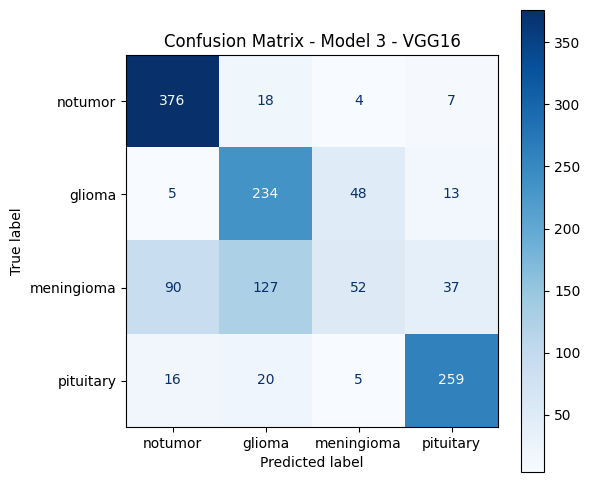

In [140]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
conf_matrix_3.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix - Model 3 - VGG16')
plt.savefig('/content/drive/MyDrive/graphs/cm_model3.jpeg', dpi = 1080)
plt.show()

In [141]:
(preds_3 == test_data_gen.classes).mean()

0.7025171624713958

In [142]:
# saving VGG16
model_3.save('/content/drive/MyDrive/cnn_models/model3.h5')
model_3.save('/content/drive/MyDrive/cnn_models/model3.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [143]:
# practice loading
load_xception = tf.keras.models.load_model('/content/drive/MyDrive/cnn_models/model2.h5')

In [144]:
load_xception.predict(test_data_gen)

41/41 [==============================] - 6s 117ms/step


array([[3.3025246e-02, 2.6659679e-03, 9.6172845e-01, 2.5803798e-03],
       [1.0000000e+00, 3.1575805e-13, 2.9170577e-08, 1.3707164e-09],
       [9.9992311e-01, 9.9848152e-10, 7.6860466e-05, 1.1636492e-08],
       ...,
       [1.0859522e-10, 1.3564924e-09, 1.0000000e+00, 3.7908534e-09],
       [6.1193731e-13, 5.1104093e-14, 1.0000000e+00, 5.6357485e-11],
       [7.4129822e-03, 7.8911401e-02, 8.6961824e-01, 4.4057343e-02]],
      dtype=float32)